In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv

import mdpy as mdp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
np.set_printoptions(precision=5, suppress=True)

# Chicken Example

In [242]:
# Solve using the matrix formulation
ns = 5
states = np.arange(ns)

I = np.eye(ns)
# transition matrix
p_forward = 0.5
p_backward = 1 - p_forward
P = np.diag(np.ones(ns-1)* p_forward, 1)
P[:,0] = p_backward
P[-1,0] = 1

# expected reward matrix & vector
R = np.zeros((ns, ns))
R[-1][0] = 1*p_forward
rvec = np.sum(P*R, axis=1)

# gamma matrix
gm = np.ones(ns)*0.9
gm[0] = 0
G = np.diag(gm)

In [76]:
P

array([[ 0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0.5,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0.5,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0.5],
       [ 1. ,  0. ,  0. ,  0. ,  0. ]])

In [236]:
P @ G

array([[ 0.  ,  0.45,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.45,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.45,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.45],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [78]:
v = pinv(I - P @ G) @ rvec

Define

$$
v(s) = r(s) + \sum_{s'} p(s, s') \gamma(s') v(s')
$$

$$
F_{s} = \sum_{s'} p(s,s') (r(s,s') + \gamma v(s'))^2 - v^2(s)
$$

With the claim that the variance of the return is then

$$
\begin{align}
\operatorname{Var}\left[{G_t| S_t = s}\right] &= \sigma_s = F_s + \gamma^2 \sum_{s'} p(s,s') \sigma_s
\\\\
\vec{\sigma} &= \vec{F} + \gamma^2 P \vec{\sigma}
\\\\
\vec{\sigma} &= (I - \gamma^2 P)^{-1} \vec{F}
\end{align}
$$

In [241]:
v * gm

array([ 0.     ,  0.04101,  0.09112,  0.2025 ,  0.45   ])

In [237]:
np.sum(P*(R + G*v)**2, axis=0)

array([ 0.25,  0.  ,  0.  ,  0.  ,  0.  ])

In [110]:
F = -(v**2).reshape(ns, 1)
for (i,j), p in np.ndenumerate(P):
    F[i] += P[i,j] * (R[i,j] + G[j,j]*v[j])**2
    
sg = pinv(I - G**2 @ P) @ F

In [197]:
P

array([[ 0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0.5,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0.5,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0.5],
       [ 1. ,  0. ,  0. ,  0. ,  0. ]])

In [198]:
R - G@v

array([[ 0.        , -0.04100625, -0.091125  , -0.2025    , -0.45      ],
       [ 0.        , -0.04100625, -0.091125  , -0.2025    , -0.45      ],
       [ 0.        , -0.04100625, -0.091125  , -0.2025    , -0.45      ],
       [ 0.        , -0.04100625, -0.091125  , -0.2025    , -0.45      ],
       [ 0.5       , -0.04100625, -0.091125  , -0.2025    , -0.45      ]])

In [206]:
P*(R + G@v)

array([[ 0.        ,  0.02050312,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.0455625 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.10125   ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.225     ],
       [ 0.5       ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [210]:
tmp = np.zeros((ns, ns))
for (i,j), p in np.ndenumerate(P):
    tmp[i,j] = P[i,j]*(R[i,j] + gm[j]*v[j])**2

In [211]:
tmp

array([[ 0.        ,  0.00084076,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00415188,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.02050313,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.10125   ],
       [ 0.25      ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [215]:
np.sum(tmp, axis=1) - v**2

array([  4.20378135e-04,   2.07594141e-03,   1.02515625e-02,
         5.06250000e-02,  -2.22044605e-16])

In [225]:
F

array([[ 0.00042],
       [ 0.00208],
       [ 0.01025],
       [ 0.05062],
       [-0.     ]])

In [226]:
(I - P @ G**2) @ F

array([[-0.00042],
       [-0.00208],
       [-0.01025],
       [ 0.05063],
       [-0.     ]])

In [227]:
sg

array([[ 0.00042],
       [ 0.01482],
       [ 0.03105],
       [ 0.05093],
       [ 0.00034]])

In [228]:
np.linalg.cond((I - G**2 @ P))

3.4948821072762777

In [191]:
num_trials = 1000
num_steps = 200

# Track returns for each trial for each state
ret_mat = np.zeros((num_trials, ns))
viz_mat = np.zeros((num_trials, ns))

for i in range(num_trials):
    # Run simulation
    s = 0
    step_lst = []
    for step in range(num_steps):
        sp = np.random.choice(states, p=P[s])
        reward = R[s, sp]
        step_lst.append([s, reward, sp])
        s = sp

    # Compute discounted return
    ret = 0.0
    for (s, r, sp) in reversed(step_lst):
        ret += r
        
        # Update records
        ret_mat[i, s] += ret
        viz_mat[i, s] += 1
        
        # Prepare for next iteration
        ret *= gm[s]

In [188]:
mc_mat = ret_mat/viz_mat

In [189]:
# Empirical variance
sg_exp = np.var(mc_mat, axis=0)

# Checking via expected mean
sg_check = np.mean(mc_mat**2, axis=0) - v**2
v_exp = np.mean(mc_mat, axis=0)

In [229]:
sg_exp

array([ 0.00006,  0.00028,  0.00117,  0.00401,  0.     ])

In [177]:
sg_exp

array([  8.73399608e-07,   3.87474506e-06,   1.35623355e-05,
         6.31122749e-05,   0.00000000e+00])

In [230]:
sg

array([[ 0.00042],
       [ 0.01482],
       [ 0.03105],
       [ 0.05093],
       [ 0.00034]])

<Container object of 5 artists>

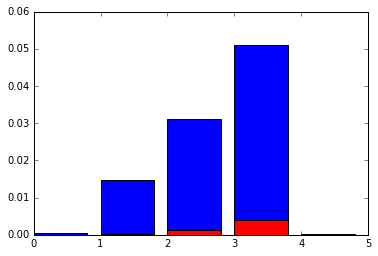

In [232]:
plt.bar(states, sg)
plt.bar(states, sg_exp, color='red')

<Container object of 5 artists>

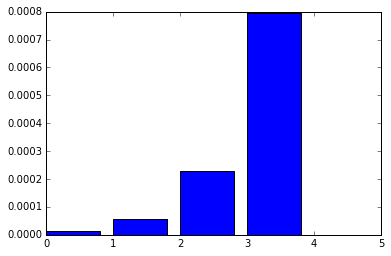

In [149]:
plt.bar(states, sg_exp)

In [145]:
v_exp

array([ 0.02052859,  0.04559857,  0.10127524,  0.22548427,  0.5       ])

In [146]:
v - v_exp

array([ -2.54605310e-05,  -3.60656976e-05,  -2.52444900e-05,
        -4.84273832e-04,   2.22044605e-16])